# Load Training data (.H5 file) using DI Datalake

In [1]:
# !pip install hdfs
from hdfs import InsecureClient
import h5py
import io
import numpy as np

client = InsecureClient('http://datalake:50070')
with client.read('/worm/data/CatImages/CatsandNoncats/train_data.h5') as reader:
    a = reader.read()
    train_dataset = h5py.File(io.BytesIO(a),"r")

train_dataset.keys()

<KeysViewHDF5 ['list_classes', 'train_set_x', 'train_set_y']>

In [2]:
train_x = np.array(train_dataset["train_set_x"][:])
train_y = np.array(train_dataset["train_set_y"][:])
train_y = train_y.reshape(1,train_y.shape[0])
classes = np.array(train_dataset["list_classes"][:])

# Load Testing data (.H5 file) using S3

In [3]:
import notebook_hana_connector.notebook_hana_connector
import boto3
import s3fs

In [4]:
di_connection = notebook_hana_connector.notebook_hana_connector.get_datahub_connection(id_="bvr_s3_files")
access_key = di_connection["contentData"]["accessKey"]
secret_key = di_connection["contentData"]["secretKey"]

In [5]:
s3 = s3fs.S3FileSystem()
client = boto3.client('s3', aws_access_key_id=access_key, 
                            aws_secret_access_key=secret_key)
bucket     = 'sapditestdata'
object_key = 'test_data.h5'
h5_obj = client.get_object(Bucket=bucket, Key=object_key)
body = h5_obj['Body']
a = body.read()
test_dataset = h5py.File(io.BytesIO(a),"r")
test_dataset.keys()       

<KeysViewHDF5 ['list_classes', 'test_set_x', 'test_set_y']>

In [6]:
test_x = np.array(test_dataset["test_set_x"][:])
test_y = np.array(test_dataset["test_set_y"][:])
test_y = test_y.reshape(1,test_y.shape[0])

In [7]:
m_train = train_x.shape[0]
m_test = test_x.shape[0]
num_px = train_x.shape[1]
print ("Number of training examples: m_train = " + str(train_x.shape[0]))
print ("Number of testing examples: m_test = " + str(test_x.shape[0]))
print ("Height/Width of each image: num_px = " + str(train_x.shape[1]))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64


In [8]:
train_set_x_flatten = train_x.reshape(m_train,-1).T
test_set_x_flatten = test_x.reshape(m_test,-1).T

train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

In [9]:
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def predict(w, b, X):   
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)    
    A = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
        if A[0,i] >= 0.5:
            Y_prediction[0,i] = 1
        else:
            Y_prediction[0,i] = 0
    return Y_prediction

In [11]:
def sigmoid(z):
    s = 1 / (1+np.exp(-z))
    return s

def propagate(w, b, X, Y):  
    m = X.shape[1]
    
    A = sigmoid(np.dot(w.T,X) + b)

    cost = (-1/m)*(np.sum((Y*np.log(A) + (1-Y)*np.log(1-A)), axis=1))
    cost = np.squeeze(cost)

    dw = (1 / m ) * (np.dot(X,((A-Y).T)))
    db = (1/m)*np.sum(A-Y,axis=1)
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [12]:
def optimize(w, b, X, Y, num_iterations, learning_rate):
    
    costs = []
    
    for i in range(num_iterations):  
        grads, cost = propagate(w, b, X, Y)    
        
        dw = grads["dw"]
        db = grads["db"]

        w = w - learning_rate*dw
        b = b - learning_rate*db
        
        if i % 100 == 0:
            print('Cost at: ', i, ' = ', cost)
            costs.append(cost)
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [13]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5):    
    
    w = np.zeros([X_train.shape[0],1])
    b = 0  
    
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations= num_iterations, learning_rate = learning_rate)
    
    w = parameters["w"]
    b = parameters["b"]
    
    Y_prediction_train = predict(w, b, X_train)    
    Y_prediction_test = predict(w, b, X_test)


    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [14]:
d = model(train_set_x, train_y, test_set_x, test_y, num_iterations = 2000, learning_rate = 0.005)

Cost at:  0  =  0.6931471805599453
Cost at:  100  =  0.5845083636993086
Cost at:  200  =  0.46694904094655476
Cost at:  300  =  0.37600686694802077
Cost at:  400  =  0.3314632893282512
Cost at:  500  =  0.30327306747438293
Cost at:  600  =  0.27987958658260487
Cost at:  700  =  0.2600421369258757
Cost at:  800  =  0.2429406846779662
Cost at:  900  =  0.22800422256726063
Cost at:  1000  =  0.2148195137844964
Cost at:  1100  =  0.20307819060644988
Cost at:  1200  =  0.19254427716706862
Cost at:  1300  =  0.18303333796883503
Cost at:  1400  =  0.17439859438448874
Cost at:  1500  =  0.16652139705400335
Cost at:  1600  =  0.15930451829756614
Cost at:  1700  =  0.15266732471296504
Cost at:  1800  =  0.1465422350398234
Cost at:  1900  =  0.1408720757031016
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


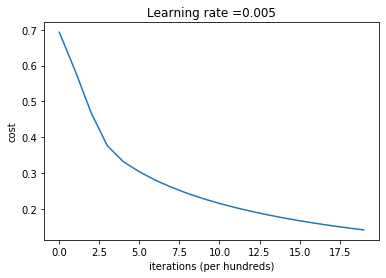

In [15]:
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

learning rate is: 0.01
Cost at:  0  =  0.6931471805599453
Cost at:  100  =  0.8239208681632827
Cost at:  200  =  0.4189444544644187
Cost at:  300  =  0.6173497041432142
Cost at:  400  =  0.5221157717538115
Cost at:  500  =  0.3877087487929267
Cost at:  600  =  0.23625445675357423
Cost at:  700  =  0.15422213306542384
Cost at:  800  =  0.1353278283151626
Cost at:  900  =  0.12497148000346776
Cost at:  1000  =  0.11647833125743959
Cost at:  1100  =  0.10919251128243944
Cost at:  1200  =  0.10280446418272444
Cost at:  1300  =  0.097129810080106
Cost at:  1400  =  0.09204326923666033
Cost at:  1500  =  0.08745251991794167
Cost at:  1600  =  0.08328603053665333
Cost at:  1700  =  0.07948657037845981
Cost at:  1800  =  0.07600734572120935
Cost at:  1900  =  0.07280949458555752
train accuracy: 99.52153110047847 %
test accuracy: 70.0 %

-------------------------------------------------------

learning rate is: 0.001
Cost at:  0  =  0.6931471805599453
Cost at:  100  =  0.5912894260003538
Cost a

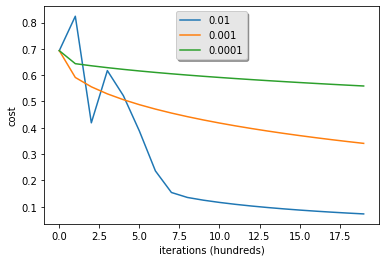

In [16]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_y, test_set_x, test_y, num_iterations = 2000, learning_rate = i)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

In [17]:
class locallinearRegression():
    def _init_(self):
        self.w = np.zeros([X_train.shape[0],1])
        self.b = 0
        self.num_px = 64
    def fit(self, w, b,num_px):
        self.w = w
        self.b = b
        self.num_px = num_px
    def predict(self, w, b, image, num_px):
        from skimage.transform import resize
        
        image = image/255
        X = resize(image,(num_px,num_px)).reshape((1, num_px*num_px*3)).T
       
        m = X.shape[1]
        Y_prediction = np.zeros((1,m))
        w = w.reshape(X.shape[0], 1)    
        A = sigmoid(np.dot(w.T, X) + b)

        for i in range(A.shape[1]):
            if A[0,i] >= 0.5:
                Y_prediction[0,i] = 1
            else:
                Y_prediction[0,i] = 0
        return Y_prediction 

In [18]:
# pip install opencv-python
# sudo python3 -m pip install opencv-contrib-python

y = 1.0, your algorithm predicts a "cat" picture.


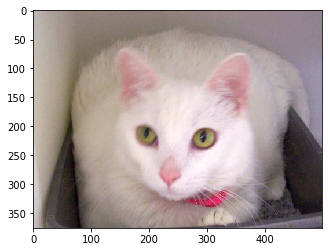

In [19]:
import pickle
from PIL import Image

my_image = "12480.jpg" 
im = Image.open(my_image)
image = np.array(im)

lm = locallinearRegression()
lm.fit(d["w"],d["b"],num_px)
pickle.dump(lm ,open( "save.p", "wb" ))
model = pickle.load( open( "save.p", "rb" ) )

my_predicted_image2 = model.predict(model.w, model.b, image,num_px)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image2)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image2)),].decode("utf-8") +  "\" picture.")

In [20]:
# pip install scikit-image

y = 0.0, your algorithm predicts a "non-cat" picture.


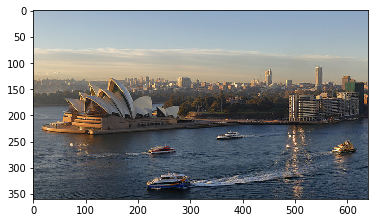

In [21]:
my_image = "Sydney-Opera-House.jpg" 
im = Image.open(my_image)
image = np.array(im)
model = pickle.load( open( "save.p", "rb" ) )

my_predicted_image2 = model.predict(model.w, model.b, image,num_px)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image2)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image2)),].decode("utf-8") +  "\" picture.")